# ``GaLeSS`` (Galaxy Lenses Search Statistics)

### This notebook provides some examples of the uses of the ``GaLeSS`` module.

### You can find more plots like the one shown below described in detail in [Ferrami & Wyithe 2024](https://arxiv.org/>)

First, let's import the relevant modules and initialise the phase space we are interested in probing.

``GaLeSS`` works by estimating the number of galaxies in a survey by sampling the lens and source populations.<br>
The lens population is characterised by range of lens masses (represented by theirs velocity dispersions) and redshifts.<br>
The source population is represented by a Luminosity Function (LF) sampled over a range of intrisic UV magnitudes and evolving with redshift.

In [1]:
import numpy as np
import galess.LensStat.lens_stat as ls
import galess.Utils.ls_utils as utils
import galess.Plots.lens_plot as lens_plot

M_array     = np.linspace(-13 , -25 , 25)
sigma_array = np.linspace(100 , 400 , 31)
zl_array    = np.arange(0.  , 2.5 , 0.1)
zs_array    = np.arange(0.  , 5.4 , 0.2)

Each combination of survey - photometric band has a ``.param`` file in the ``data/survey_params`` folder in this repo,<br>
which contains the relevant input parameters to ``GaLeSS``.<br>
Here is the list of the file headers:

In [4]:
surveys_titles = [
     'COSMOS Web F115W', 'COSMOS Web F150W', 'COSMOS Web F277W',
     'PEARLS NEP F115W', 'PEARLS NEP F150W', 'PEARLS NEP F277W',
     'JADES Deep F115W', 'JADES Deep F150W', 'JADES Deep F277W',
     'COSMOS HST i band',
     'DES i band',
     'SUBARU HSC SuGOHI i band',
     'EUCLID Wide VIS',
     'Roman HLWA J',
     'LSST i band', 'LSSTsinglevisit i band'
     'CFHTLS i band']

Here is an example of such parameters contained in `EUCLID Wide VIS.param`:
```python
{
title: 'EUCLID Wide VIS'
limit: 26.2
cut: 25
area: 15000
seeing: 0.17
exp_time_sec: 1610
pixel_arcsec: 0.1
zero_point_m: 25.5
sky_bckgnd_m: 22.2
photo_band: 'sdss_i0'
}
```
<br>
<br>
Other two input parameters we need to provide are the minimal value of signal-to-noise and magnification<br>
at which a lens becomes identifiable.<br>
To remain consistent with some of the past literature ion the topic, we choose:

In [3]:
min_SNR     = 20
arc_mu_thr  = 3

We can now run the model using the input parameters we discussed so far.<br>
The only missing information is whether we want to estimate a lens search in which the lens galaxy light profile is completely removed,<br>
or accounting for its foreground light. This is controlled by the `LENS_LIGHT_FLAG`.<br>
(There is one last ingredient to the recipe, the assumed Velocity Dispersion Function, or VDF, but we'll discuss it later).<br><br>
Below is a sample run on the `LSST i band`, try to change it to `COSMOS Web F115W`!<br>

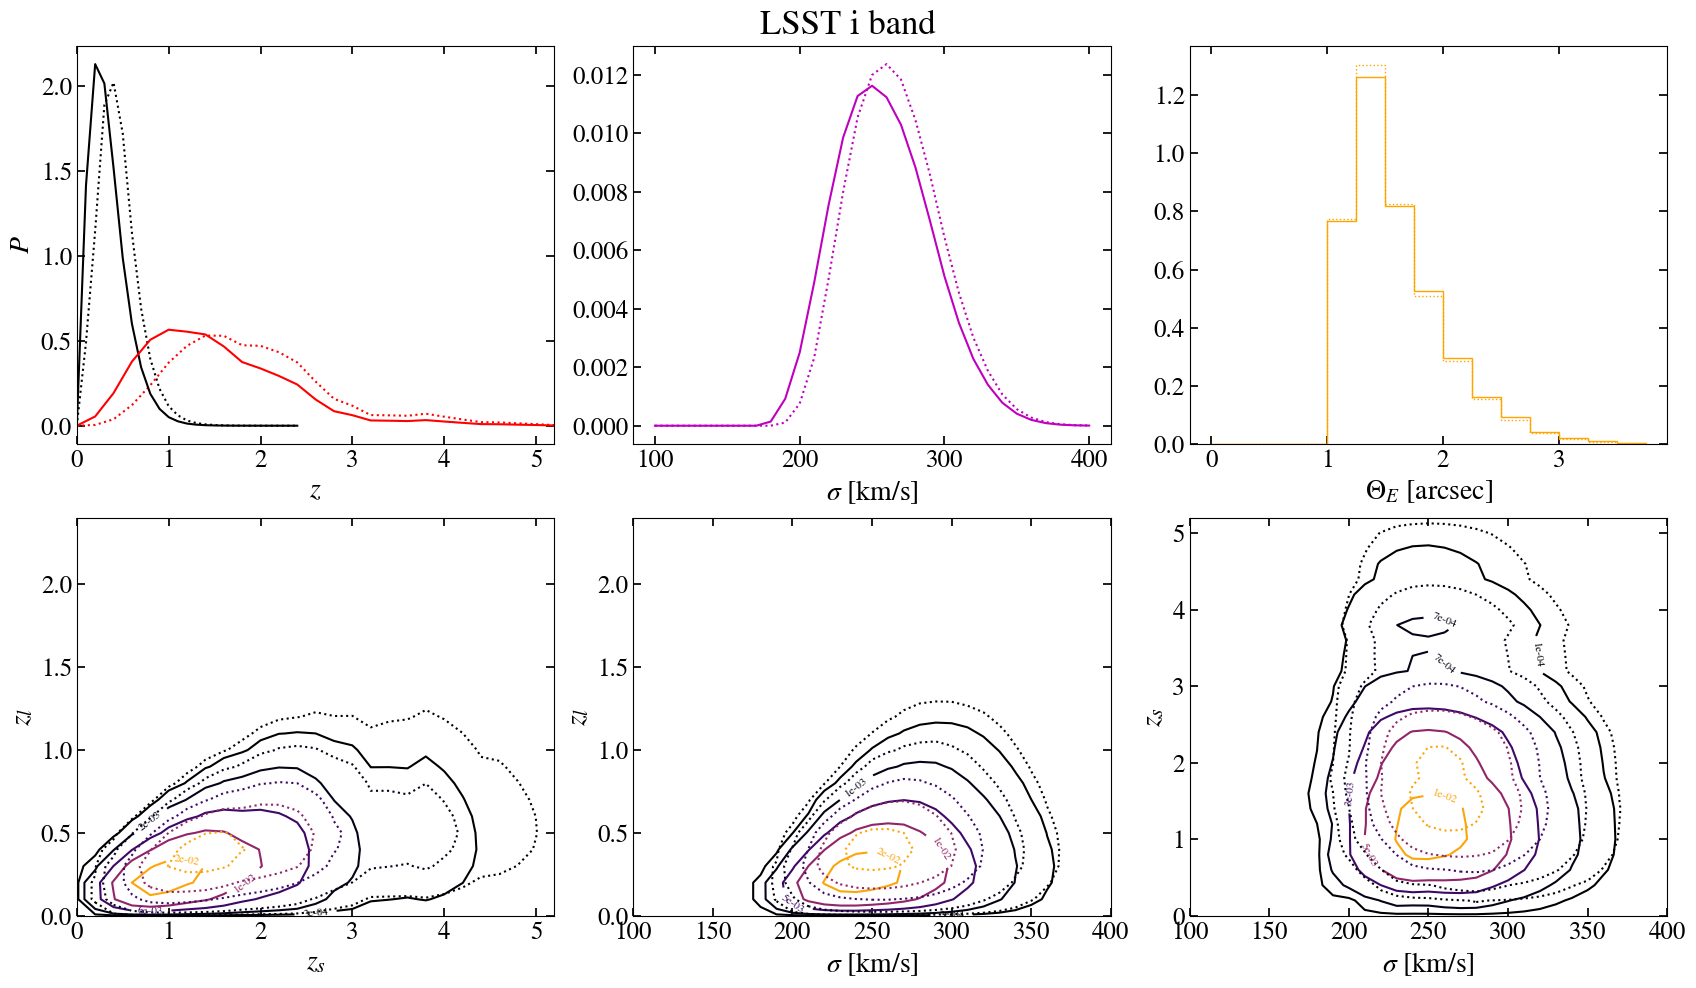

In [2]:
for title in ['LSST i band']: #Try 'COSMOS Web F115W'!
     survey_params = utils.read_survey_params(title, VERBOSE = 0)
     limit    = survey_params['limit']
     cut      = survey_params['cut']
     area     = survey_params['area']
     seeing   = survey_params['seeing']
     exp_time_sec = survey_params['exp_time_sec']
     zero_point_m = survey_params['zero_point_m']
     sky_bckgnd_m = survey_params['sky_bckgnd_m']
     photo_band   = survey_params['photo_band']

     try:
          matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
     except ValueError:
          print('FILE do NOT exist - RUNNING MODEL')
          matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                  sigma_array, zl_array, zs_array, M_array, limit, area,
                                                  seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                  photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr,
                                                  Phi_vel_disp = ls.Phi_vel_disp_Mason, LENS_LIGHT_FLAG = False)
          matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                  sigma_array, zl_array, zs_array, M_array, limit, area,
                                                  seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                  photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr,
                                                  Phi_vel_disp = ls.Phi_vel_disp_Mason, LENS_LIGHT_FLAG = True)
          utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)

     lens_plot.plot_ALL_distributions(title, zl_array, zs_array, sigma_array,
                                   Theta_E_LL, matrix_LL, Theta_E_noLL, matrix_noLL,
                                   PLOT_FOR_KEYNOTE = 0, SMOOTH = 1, SAVE = 0)

With this setup, we can now compute the surveys we want, and store it for faster plotting later.<br>
There is also an utility function that prints a summary of the model results for each survey:

In [3]:
utils.print_summary_surveys(['LSST i band', 'COSMOS HST i band'])

|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)       |

|       LSST i band       |           0.750|     20000.000|         25.0|         26.8|          11|  2.2e+05 (  8.2e+04)|

|    COSMOS HST i band    |           0.120|         1.600|         25.0|         26.5|          27|       44 (       17)|



Here we compare the 1-D probability distributions over redshift, velocity dispersion and Einstein Radius for a set of surveys.

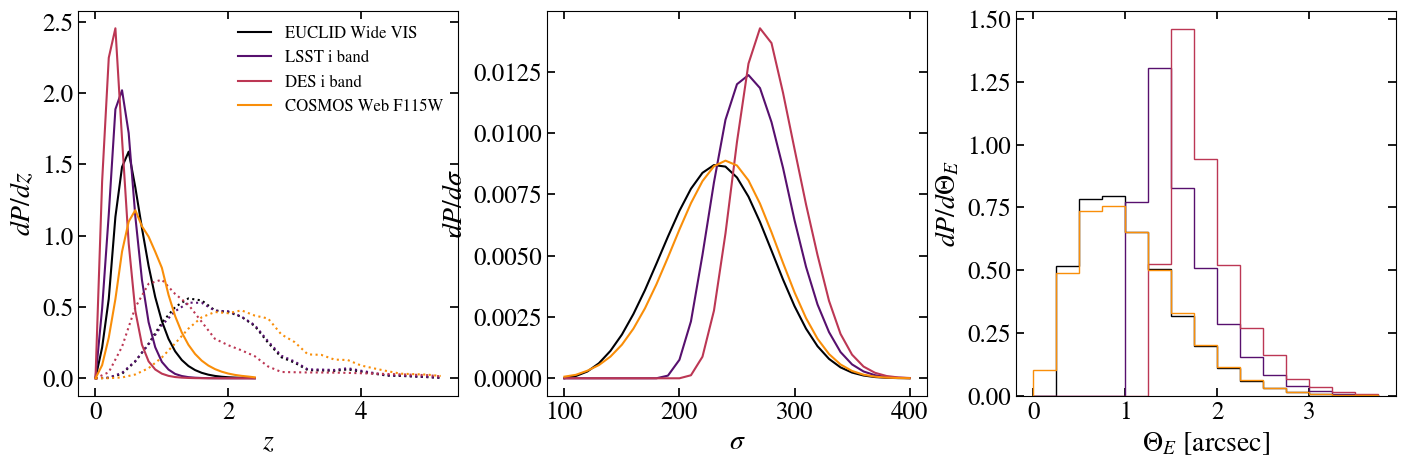

In [4]:
surveys_selection = ['EUCLID Wide VIS', 'LSST i band', 'DES i band', 'COSMOS Web F115W']
lens_plot.compare_ALL_distributions_surveys(surveys_selection, sigma_array, zl_array, zs_array)

### ``MODEL RESPONSE TO INPUT PARAMETERS:`` <span style="color: orange"> VDF </span>
As briefly mentioned above, the assumption made on the lens mass distribution and evolution with redshift,<br>
represented by the Velocity Dispersion Funcition (VDF), is an important input in our model, which at the moment<br>
is not very well constrained at all.<br>
<br>
Here is a plot that shows the prediction fot `EUCLID Wide VIS` with no lens light for 3 different choices of VDF:

FILE do NOT exist - RUNNING MODEL


100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


FILE do NOT exist - RUNNING MODEL


100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


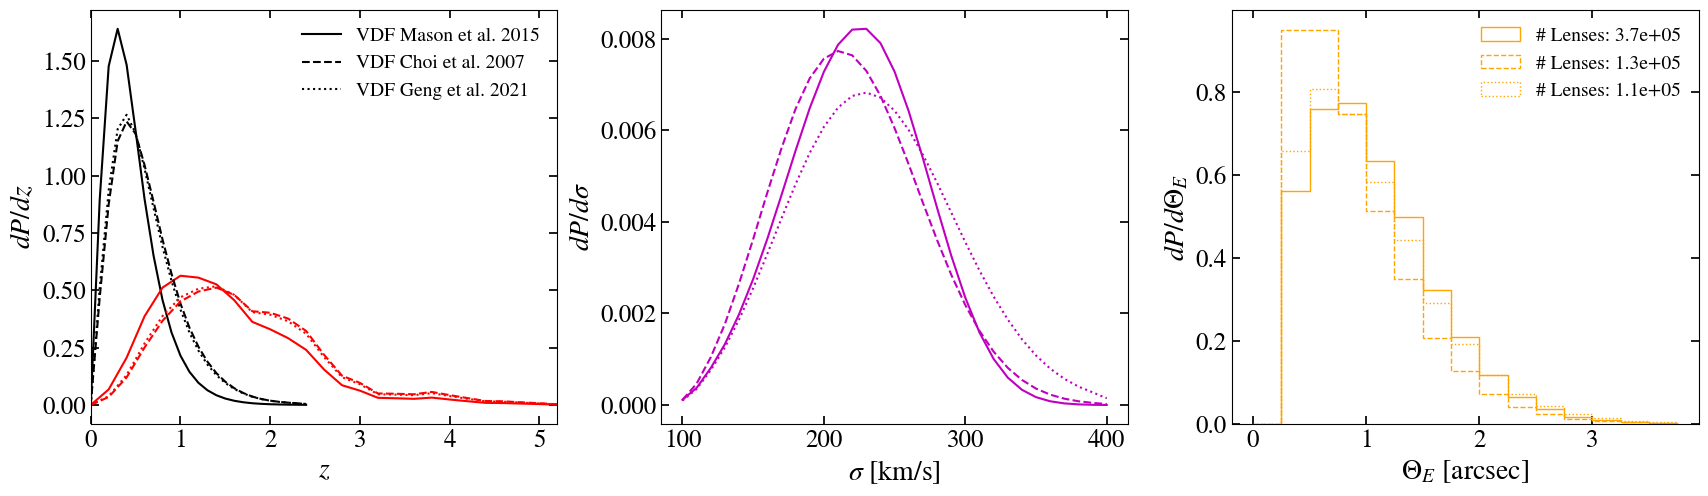

In [10]:
lens_plot.plot_effect_vel_disp_function(zl_array, zs_array, sigma_array, LENS_LIGHT = 0, SMOOTH = 1, READ_FILES = 1)

### ``MODEL RESPONSE TO INPUT PARAMETERS:`` <span style="color: orange"> m<sub>cut</sub></span> 

Another example of the model response to input parameters is the cut in magnitude m<sub>cut</sub> imposed on the survey data.
Shown below is the effect of m<sub>cut</sub> on the 1-D distributions and on the total number of lenses.

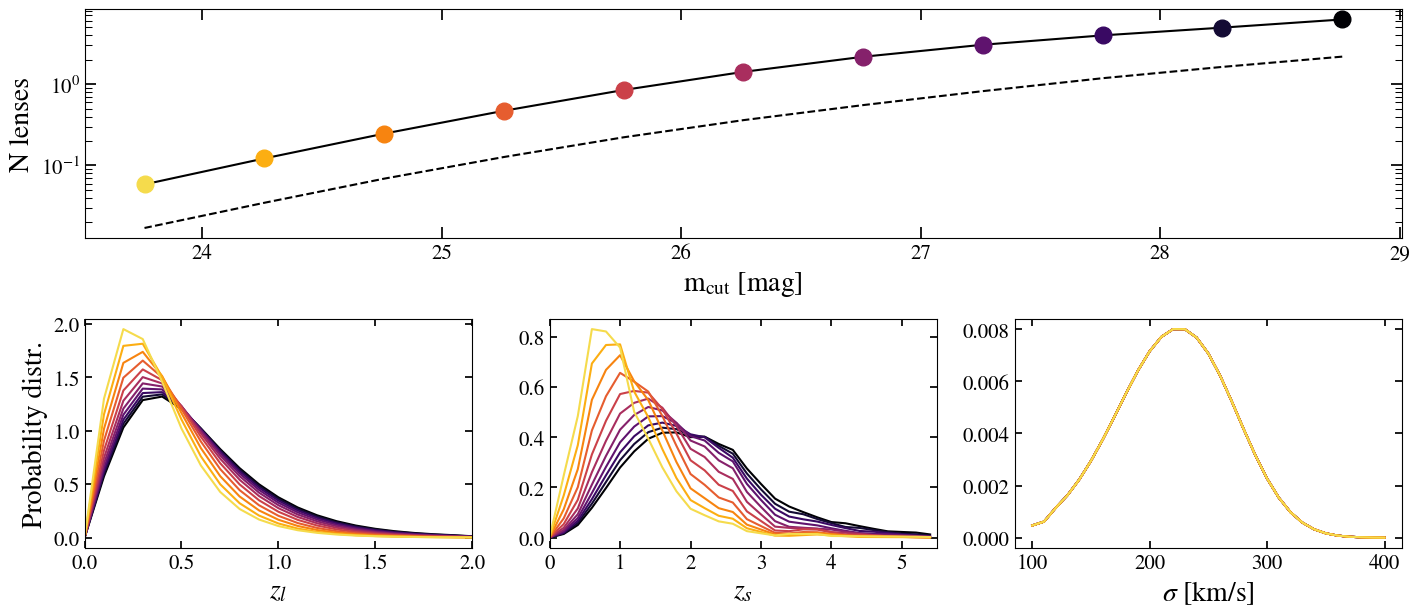

In [6]:
lens_plot.model_response_m_cut()
# P.S. This might take a while the first time you run it, since it has to
# compute 11x2 models (varying m<sub>cut</sub>, with and without lens light).

### ``TESTING AGAINST OBSERVED LENS SAMPLES``

``GaLeSS`` can be used to compare models with varying input parameters to past lens searches.<br>
Here we show the full SL2S sample from [Sonnenfeld et al. 2013](http://dx.doi.org/10.1088/0004-637X/777/2/98) with ``GaLeSS`` output with two different VDF as a input.

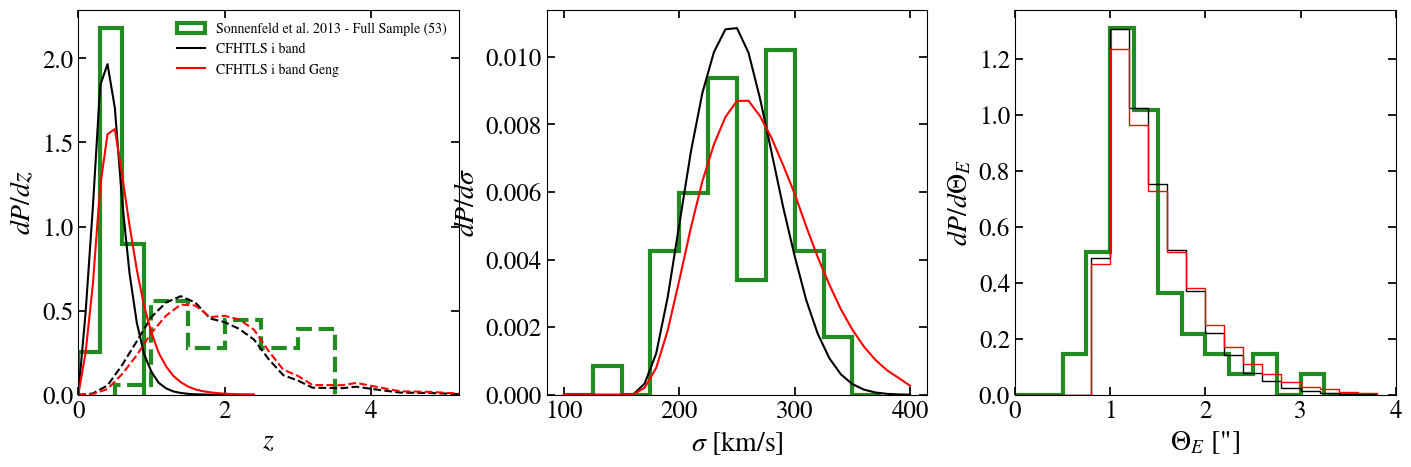

In [7]:
lens_plot.compare_SL2S(zl_array, zs_array, sigma_array, LENS_LIGHT = 1)